In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from matplotlib.ticker import MultipleLocator
import requests
from scipy.optimize import curve_fit

# Empirical models and fitting

The goal of this notebook is to introduce Empirical models and tie them to the modeling process we discussed at the beginning of the course. In particular, we are intrested in answering the following questions:

1. **What is an empirical model?**
1. **When is an empirical model reliable?** Under what conditions can we trust the model to make accurate predictions (e.g., interpolation vs. extrapolation
1. **How do we find the best fit parameters that define an emprical model?** How do we define *best-fit*? How can we automate the process using a computer?


**Before continuing, go to the menu and seleect `Runtime->Run all`**

# What is an empirical model?

An **empirical model** is a *data driven* model. It arises from some experimental or simulated data we have about the world. Our goal in constructing an empirical model is to find some mathematical function that describes the data. We do not care what this function is, and it can have absolutely no connection to the processes that underlay the data. All it has to do is *describe* the data, not *explain* the data. This is a critical distinction that fundamentally limits what we can use an empirical model for, but greatly simplifies its construction.

Let's dig into that last statement some more. When we are trying to describe some data with a mathematical function, there are two broad approaches we can take.

In the first approach, we can analyze the system and using knowledge about the system or physical laws, come up with (i.e. derive) an equation that reflects the underlying process we are modeling. We will call these **derived models**. One of the easiest places to do this is in physics where we can often write down an equation for how we expect the data to look given the physical senario. In this situation, our model can both describe the data (does our equation match the data?) and explain the data (the parameters in our function have some clear connection to the underlying system we are modeling).

For example, if we some data describing the position of a tennis ball above the ground as a function of time (shown below). We can fit that data to the function
$$y = a + b t + \frac{c}{2} t^2 $$
where $a$ is the initial position of the ball in, $b$ is the initial velocity of the ball in the y-direction, and $c$ is the acceleration of the ball in the y-direction.

Each of these parameters has a well defined meaning in the context of the problem and would allow us to continue to predict the position of the ball into the future after we have stopped making measurements. In other words, because the parameters are linked to physical processes derived models allow us the **explain** the data, and **extrapolate** into regions where we do not have data.

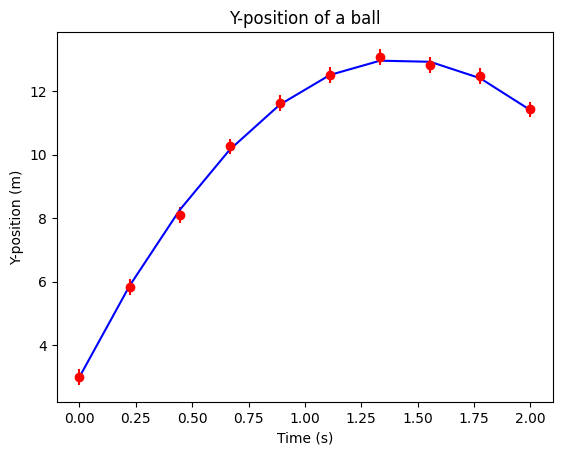

In [25]:
#@title Tennis ball over time

a = 3 #@param {type:"number"}
b = 14 #@param {type:"number"}
c = -9.8 # @param {"type":"number"}

t = np.linspace(0, 2, 10)
y = lambda t: a + b * t + 0.5 * c * t**2
ydata =y(t)
#add some gauss noise to data
ydata += np.random.normal(0, 0.1, len(t))
ymodel = y(t)

plt.errorbar(t, ydata, yerr=0.25, fmt="ro")
plt.plot(t, ymodel, "b-")
plt.xlabel('Time (s)')
plt.ylabel('Y-position (m)')
plt.title('Y-position of a ball')
plt.show()


This is in stark contrast to an emperical model, where we do no analysis of the system before choosing a mathematical function to describe the data. In an empirical model, the function allows us to **describe** the data, and make predictions in the region where we have data. Predicting data points in the region where we already have data is called **interpolation**. However, since the model has no explanatory power, we cannot extrapolate to regions that were not included in our fit.

This begs an obvious question: *how do we pick the mathematical function we use to describe the data?*

 And the answer is simply: you choose! Often, this involves trying different types of functions—linear, quadratic, exponential—and selecting the one that best fits the data. You can always make a polynomial of sufficiently high order describe any data set, but often times there is a *natural* function to choose. The best thing to do is plot the data and then try out some functions that look reasonable!

Let's take a look at the first exmaple we ever saw for an empirical model:

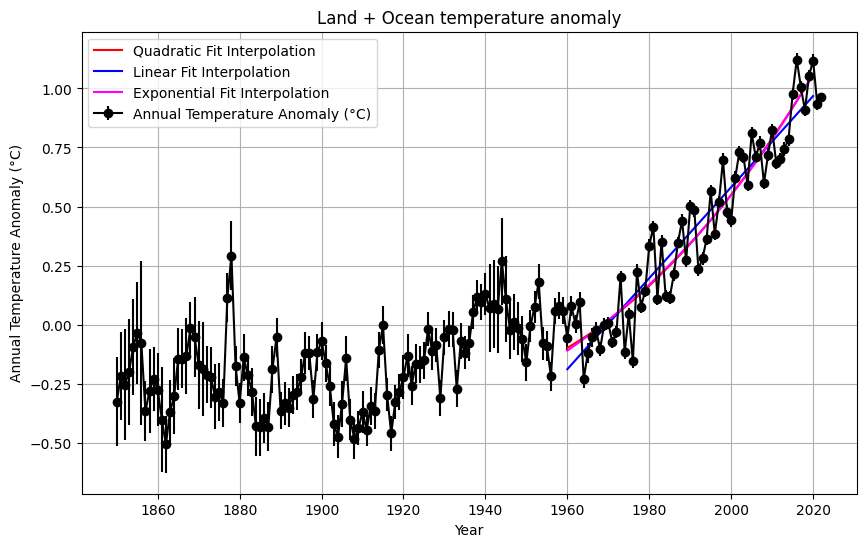

In [38]:
#@title Earth surface temperature anomaly


# Define the URL for the data file
url = "https://berkeley-earth-temperature-hr.s3.amazonaws.com/Global_TAVG_annual.txt"

# Function to skip lines starting with '%'
def skip_comments(file):
    for line in file:
        if not line.startswith('%'):
            yield line

# Initialize empty lists for years and temperatures
years = []
temperatures = []
errors = []

# Fetch data from the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Decode the content and split it into lines
    lines = response.text.splitlines()


    # Iterate through non-comment lines and extract data
    for line in skip_comments(lines):
        data = line.split()  # Split the line into columns
        if(len(data) == 0):
          continue
        year = int(data[0])  # Year is in the first column
        temperature = float(data[1])  # Temperature is in the second column
        error = float(data[2])  # Error is in the third column

        # Append data to the respective lists
        years.append(year)
        temperatures.append(temperature)
        errors.append(error)


    # Convert lists to numpy arrays for plotting
    years = np.array(years)
    temperatures = np.array(temperatures)
    errors = np.array(errors)

    # Filter data from 1960 to 2023
    mask = (years >= 1960) & (years <= 2020)
    years_filtered = years[mask]
    temperatures_filtered = temperatures[mask]

    # Define a quadratic function for fitting
    def quadratic_fit(x, a, b, c):
        return a * x**2 + b * x + c
    # Define a linear function for fitting
    def linear_fit(x, a, b):
        return a + b * x
    #Define an exponetial function for fitting
    def exponential_fit(x, a, b, c, d):
        return a * np.exp(b * (x - c)) + d

    # Fit the data with the quadratic function
    popt, _ = curve_fit(quadratic_fit, years_filtered, temperatures_filtered)
    popt_linear, _ = curve_fit(linear_fit, years_filtered, temperatures_filtered)
    popt_exp, _ = curve_fit(exponential_fit, years_filtered, temperatures_filtered, p0=(1, 1, 1960, -1))

    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(years, temperatures, yerr=errors, fmt='o-', color='black', label='Annual Temperature Anomaly (°C)')

    # Generate values for the fitted curve
    curve_years = np.linspace(1960, 2020, 1000)
    fitted_curve = quadratic_fit(curve_years, *popt)
    fitted_curve_linear = linear_fit(curve_years, *popt_linear)
    fitted_curve_exp = exponential_fit(curve_years, *popt_exp)

    pre_fit_years = np.linspace(1850, 1960, 1000)
    pre_fit_curve = quadratic_fit(pre_fit_years, *popt)

    # Plot the fitted curve
    plt.plot(curve_years, fitted_curve, '-', label='Quadratic Fit Interpolation', color='red')
    plt.plot(curve_years, fitted_curve_linear, '-', label='Linear Fit Interpolation', color='blue')
    plt.plot(curve_years, fitted_curve_exp, '-', label='Exponential Fit Interpolation', color='magenta')
    #plt.plot(pre_fit_years, pre_fit_curve, '-', label='Quadratic Fit Extrapolation', color='blue')

    plt.title('Land + Ocean temperature anomaly')
    plt.xlabel('Year')
    plt.ylabel('Annual Temperature Anomaly (°C)')
    plt.grid(True)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(20))
    plt.show()
else:
    print("Failed to fetch data. Status code:", response.status_code)


In this example, we are fitting the annual surface temperature anomaly from 1960 to 2020 to a quadratic function (in red)
$$y = a + bt + ct^2,$$
a linear function (in blue)
$$y = a + bt,$$
and an exponential function (in magenta)
$$ y = a e^{b(t-c)} + d.$$

Notice all three of these do a reasonable job of describing the data. In fact, the exponential and quadratic fits sit almost entirely on top of each other! All three of these would be perfectly valid empirical models of the annual surface temperature anomaly from 1960 to 2020.

# When is an empirical model reliable?

Let's talk a little bit more about this idea of **extrapolation** vs **interpolation**. Making predictions within the range of your observed data is known as interpolation, while trying to predict beyond that range is called extrapolation. Empirical models are typically reliable for interpolation but not for extrapolation. Let's take a look at what happens to our empirical models from above when we extraplate them to earlier years.

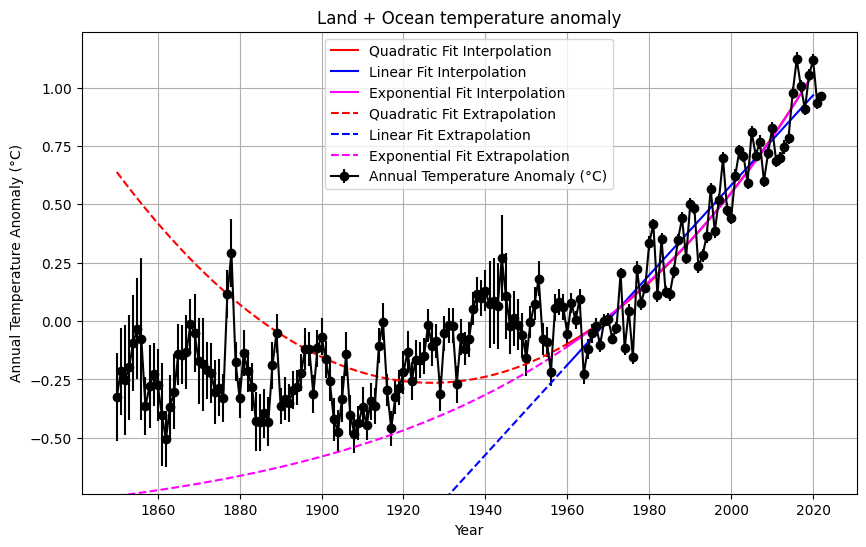

In [42]:
#@title Earth surface temperature anomaly


# Define the URL for the data file
url = "https://berkeley-earth-temperature-hr.s3.amazonaws.com/Global_TAVG_annual.txt"

# Function to skip lines starting with '%'
def skip_comments(file):
    for line in file:
        if not line.startswith('%'):
            yield line

# Initialize empty lists for years and temperatures
years = []
temperatures = []
errors = []

# Fetch data from the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Decode the content and split it into lines
    lines = response.text.splitlines()


    # Iterate through non-comment lines and extract data
    for line in skip_comments(lines):
        data = line.split()  # Split the line into columns
        if(len(data) == 0):
          continue
        year = int(data[0])  # Year is in the first column
        temperature = float(data[1])  # Temperature is in the second column
        error = float(data[2])  # Error is in the third column

        # Append data to the respective lists
        years.append(year)
        temperatures.append(temperature)
        errors.append(error)


    # Convert lists to numpy arrays for plotting
    years = np.array(years)
    temperatures = np.array(temperatures)
    errors = np.array(errors)

    # Filter data from 1960 to 2023
    mask = (years >= 1960) & (years <= 2020)
    years_filtered = years[mask]
    temperatures_filtered = temperatures[mask]

    # Define a quadratic function for fitting
    def quadratic_fit(x, a, b, c):
        return a * x**2 + b * x + c
    # Define a linear function for fitting
    def linear_fit(x, a, b):
        return a + b * x
    #Define an exponetial function for fitting
    def exponential_fit(x, a, b, c, d):
        return a * np.exp(b * (x - c)) + d

    # Fit the data with the quadratic function
    popt, _ = curve_fit(quadratic_fit, years_filtered, temperatures_filtered)
    popt_linear, _ = curve_fit(linear_fit, years_filtered, temperatures_filtered)
    popt_exp, _ = curve_fit(exponential_fit, years_filtered, temperatures_filtered, p0=(1, 1, 1960, -1))

    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(years, temperatures, yerr=errors, fmt='o-', color='black', label='Annual Temperature Anomaly (°C)')

    # Generate values for the fitted curve
    curve_years = np.linspace(1960, 2020, 1000)
    fitted_curve = quadratic_fit(curve_years, *popt)

    pre_fit_years = np.linspace(1850, 1960, 1000)
    pre_fit_curve = quadratic_fit(pre_fit_years, *popt)
    pre_fit_curve_linear = linear_fit(pre_fit_years, *popt_linear)
    pre_fit_curve_exp = exponential_fit(pre_fit_years, *popt_exp)

    # Plot the fitted curve
    plt.plot(curve_years, fitted_curve, '-', label='Quadratic Fit Interpolation', color='red')
    plt.plot(curve_years, fitted_curve_linear, '-', label='Linear Fit Interpolation', color='blue')
    plt.plot(curve_years, fitted_curve_exp, '-', label='Exponential Fit Interpolation', color='magenta')

    plt.plot(pre_fit_years, pre_fit_curve, '--', label='Quadratic Fit Extrapolation', color='red')
    plt.plot(pre_fit_years, pre_fit_curve_linear, '--', label='Linear Fit Extrapolation', color='blue')
    plt.plot(pre_fit_years, pre_fit_curve_exp, '--', label='Exponential Fit Extrapolation', color='magenta')

    plt.title('Land + Ocean temperature anomaly')
    plt.xlabel('Year')
    plt.ylabel('Annual Temperature Anomaly (°C)')
    plt.ylim(-0.74, 1.24)
    plt.grid(True)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(20))
    plt.show()

else:
    print("Failed to fetch data. Status code:", response.status_code)


In all three examples, once we extend past the fit range (the transition from solid to dashed curves) all three models **quickly** diverge from the data. And they all diverge in different ways! This is what happens when you try to **extrapolate** an empirical model into a range where no data was included in the fit, and why it is always a bad idea to try to extraolate with emperical models.

# How do we find the best fit parameters that define an emprical model?

The final thing we need to discuss is: how do we find the numeric values of the constants in our empirical models? We want the **best-fit** parameters, which are the numeric values where the model will best describe the data. To answer that questions we must first ask another: How do we describe how well a model matches the data?

The first thing we might do is look at the difference between the models prediction and the experimental data. Suppose we have some set of measurements of the dependent variable $y$, ${y_0, y_1, y_2, ..., y_{N-1}}$, made at ${x_0,x_1,x_2,..., x_{N-1}}$. The difference between the model and prediction is called the **residual** and if our model is described by the function $f(x)$, then the residual for the point $(x_0,y_0)$ would be
$$
\text{residual} = y_o - f(x_0).$$

For many data points, we can talk about the *sum* of the residuals for each data point
$$\sum_i^{N-1} y_i - f(x_i)$$

As our data and model get closer and closer to together, this sum should go to zero. Let's take a look at this in action. Below I have ploted some linear data and given you sliders to control the model parameters. **Find the model parameters that get the residual closest to 0.**

The sum of the residuals is -15.00
The sum of the square of the resitduals is 67.50


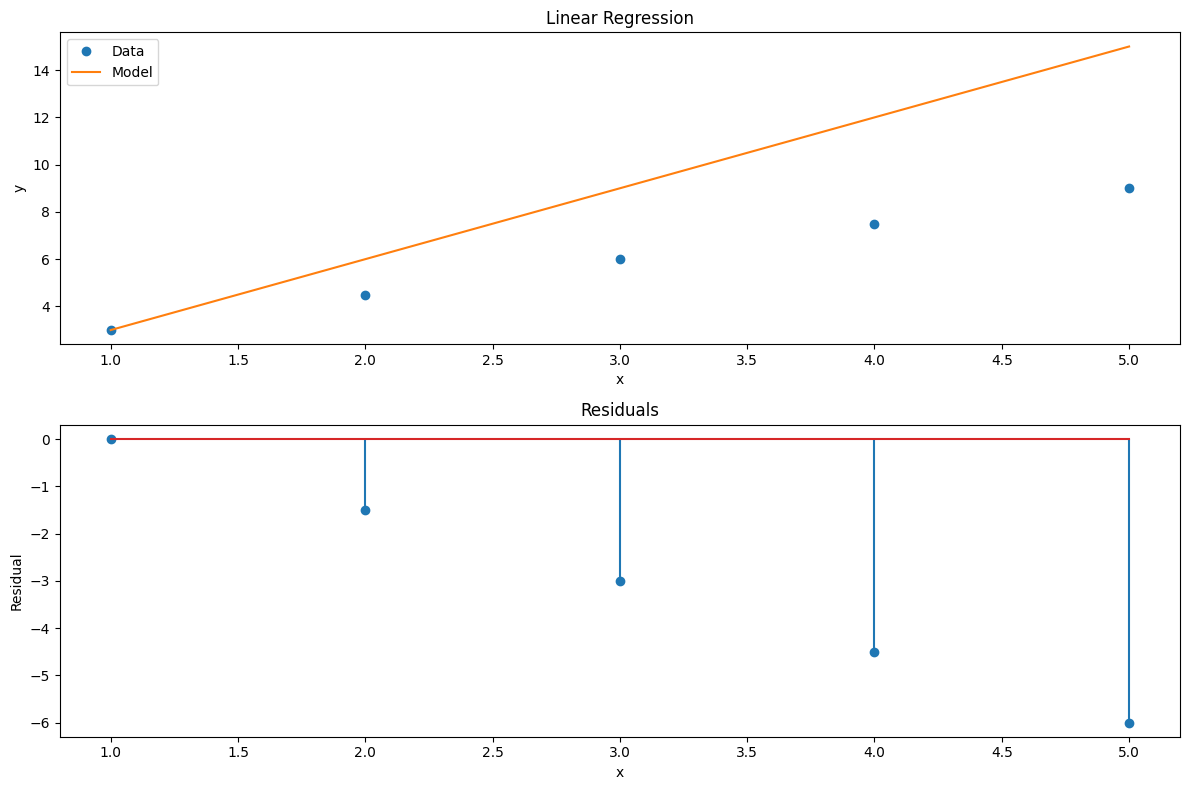

In [61]:
#@title Linear Regression with Residuals {run: "auto"}

slope = 3  #@param {type:"slider", min:-5, max:5, step:0.1}
intercept = 0  #@param {type:"slider", min:-5, max:5, step:0.1}


x_data = np.array([1, 2, 3, 4, 5])
y_data = np.array([3, 4.5, 6, 7.5, 9])


y_model = slope * x_data + intercept


residuals = y_data - y_model

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(x_data, y_data, 'o', label='Data')
axs[0].plot(x_data, y_model, '-', label='Model')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Linear Regression')
axs[0].legend()

axs[1].stem(x_data, residuals)
axs[1].set_xlabel('x')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals')

plt.tight_layout()
print(f"The sum of the residuals is {sum(residuals):.2f}")
print(f"The sum of the square of the residuals is {sum(residuals**2):.2f}")
plt.show()

This works well for humans, but finding zero like this is a harder problem for a computer than *minimizing* a number. What we mean by *minimize* is make as small as possible, so if we tried to minimize the sum of the residuals we would end up with a bad fit with a very large negative number!

Instead, we typically minimize the *square* of the residual, so it is always positive. Whatever we choose to minimize is called our **loss function** or our **objective function**. In the case of the square of the residual, our loss function would be defined as

$$\text{loss} = \sum_i^{N-1} (y_i - f(x_i))^2$$.

This method is called a **least-squares** minimization and is what we will use whenever we do this type of minimization using python. Notice in the example above that this value is always positive and increase as the sum of the residuals gets more neagative.

Depending on the difficulty of the problem, you can start to get clever with defining loss functions specific to your problem but we will not deal with that in this class.